# Take ground-truth binary maps and sample weights from eo-patches

In [1]:
%matplotlib inline

# Built-in modules
import os
import sys
import json
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import skewnorm
from skimage import measure
from skimage.morphology import binary_dilation, disk

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn
from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LoadTask)
from eolearn.io import GeoDBVectorImportTask
from eolearn.geometry import VectorToRaster

Taking the target binary maps (cultivated/non-cultivated) and relative sample weights from the eo-patches, as defined in the starter pack

In [2]:
geodb_client_id = 'cd297e67cc244e7eb11187eb7ca5c03a'
geodb_client_secret = '1Wk77l0X2Xb4NVjRIgVOWDgKduy3rypyYt-Qqb_dMI4'

client = GeoDBClient()
client.whoami

# DO NOT CHANGE THIS
GEODB_DATABASE = 'geodb_0e5d743f-2134-4561-8946-a073b039176f'

EOPATCHES_PATH = 'eopatches'

MAP_RESOLUTION = 2.5 # metres

/opt/conda/envs/eurodatacube-gpu-0.24.5/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
with open(os.environ['EXTRA_PATH'] + 'metadata/cultivated-mapping.json') as jfile:
    cultivated_mapping = {int(k): v for k, v in json.load(jfile).items()}
with open(os.environ['EXTRA_PATH'] + 'metadata/label-names.json') as jfile:
    label_names = {int(k): v for k, v in json.load(jfile).items()}

In [4]:
valid_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'CULTIVATED'),
    values=cultivated_mapping[1],
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint8,  
    all_touched=False,
    buffer=-MAP_RESOLUTION  # DO NOT CHANGE THIS BUFFER
)

invalid_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
    values=cultivated_mapping[2],
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint8,
    all_touched=False,
    buffer=-MAP_RESOLUTION  # DO NOT CHANGE THIS BUFFER
)

all_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'ALL_POLYS'),
    values=None,
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint16,
    all_touched=False,
    buffer=-MAP_RESOLUTION  # you can modify this buffer
)

class ToBinaryTask(EOTask):
    """ Turn a discrete feature to a binary mask """
    def __init__(self, feature: Tuple[FeatureType, str]):
        """ 
        :param feature: Feature in eopatch to binarise 
        """
        self.feature = feature
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        """ Overwrite existing feature with binary mask """
        eopatch[self.feature] = eopatch[self.feature] > 0
        return eopatch

valid_to_binary = ToBinaryTask((FeatureType.MASK_TIMELESS, 'CULTIVATED'))
invalid_to_binary = ToBinaryTask((FeatureType.MASK_TIMELESS, 'NOT_DECLARED'))

In [5]:
def weighting_function(pix_size: int, median_pix_size: int, highest_weight_pix_size: int = 35,
                       skewness: int = 15) -> float:
    """ Creates weight to be applied to a parcel depending on its number of pixels (after pixelation) """
    if pix_size >= median_pix_size:
        return 1
    
    xs = np.linspace(1, median_pix_size, median_pix_size)
    y1 = skewnorm.pdf(xs, skewness, loc=highest_weight_pix_size-100/3.14, scale=100)
    y1 = y1 / max(y1)
    y1 = y1 + 1

    return y1[int(pix_size)].astype(np.float)


class AddWeightMapTask(EOTask):
    """ Computes the weight map used to compute the validation metric """

    def __init__(self, 
                 cultivated_feature: Tuple[FeatureType, str], 
                 not_declared_feature: Tuple[FeatureType, str], 
                 weight_feature: Tuple[FeatureType, str], 
                 radius: int = 2, seed: int = 4321):
        self.cultivated_feature = cultivated_feature
        self.not_declared_feature = not_declared_feature
        self.weight_feature = weight_feature
        self.radius = radius
        self.seed = seed
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        cultivated = eopatch[self.cultivated_feature].astype(np.uint8).squeeze()
        not_declared = eopatch[self.not_declared_feature].squeeze()

        np.random.seed(self.seed)

        # compute connected components on binary mask
        conn_comp = measure.label(cultivated, background=0)
        # number of connected components
        n_comp = np.max(conn_comp) + 1

        # Placeholder for outputs
        height, width = cultivated.shape
        weights = np.zeros((height, width), dtype=np.float32)
        contours = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.uint8)

        # Loop over connected components, ignoring background
        for ncc in np.arange(1, n_comp):
            parcel_mask = conn_comp == ncc
            # number of pixels of each component, i.e. parcel
            n_pixels = np.sum(parcel_mask)

            # compute external boundary of parcel 
            dilated_mask = binary_dilation(parcel_mask, selem=disk(radius=self.radius))
            contour = np.logical_and(~parcel_mask, dilated_mask)

            weight = weighting_function(n_pixels, median_pix_size=400)

            weights[parcel_mask] = weight
            contours += 2 * weight * contour
            # In case countours overlap, the average weight is taken
            counts += contour

        # combine weights from all parcels into a single map. First add (averaged) contours,
        # then weighted parcels, then background 
        weight_map = np.zeros((height, width), dtype=np.float32)
        weight_map[contours > 0] = contours[contours > 0] / counts[contours > 0]
        weight_map[weights > 0] = weights[weights > 0]
        weight_map[weight_map == 0] = 1

        # add zero weights at border and undeclared parcels
        weight_map[not_declared == True] = 0
        weight_map[:1, :] = 0
        weight_map[:, :1] = 0
        weight_map[-2:, :] = 0
        weight_map[:, -2:] = 0

        eopatch[self.weight_feature] = weight_map[..., np.newaxis]
        
        return eopatch

add_weight = AddWeightMapTask(
    (FeatureType.MASK_TIMELESS, 'CULTIVATED'), 
    (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
    (FeatureType.DATA_TIMELESS, 'WEIGHTS')
)

Load eo-patches from training set and run the previously defined tasks for taking and storing both ground-truth binary maps and sample weights

In [9]:
load = LoadTask(path=EOPATCHES_PATH)
get_polys = GeoDBVectorImportTask(
    feature=(FeatureType.VECTOR_TIMELESS, 'REFERENCE'), 
    geodb_client=client, 
    geodb_collection='ai4eo_reference',
    geodb_db=GEODB_DATABASE
    )
bboxes = client.get_collection('ai4eo_bboxes', database=GEODB_DATABASE)

train_ids = np.array([str(k) for k in bboxes.eop_index])
names_gt = np.array([(str(k) if len(str(k))>1 else '0'+str(k)) + '-gt' for k in range(len(bboxes))])
names_w = np.array([(str(k) if len(str(k))>1 else '0'+str(k)) + '-weights' for k in range(len(bboxes))])

pbar = tqdm(total=len(train_ids), file=sys.stdout, desc='Progress')
for k, idx in enumerate(train_ids):
    eop = load.execute(eopatch_folder=f'train/eopatch-{idx}')
    eop = get_polys.execute(eopatch=eop)
    eop = valid_polys_to_mask.execute(eop)
    eop = invalid_polys_to_mask.execute(eop)
    eop = all_polys_to_mask.execute(eop)
    eop = valid_to_binary.execute(eop)
    eop = invalid_to_binary.execute(eop)
    eop = add_weight.execute(eop)
    
    gt = eop.mask_timeless['CULTIVATED']
    np.savez_compressed('./data/train/' + names_gt[k], gt)
    
    weights = eop.data_timeless['WEIGHTS']
    np.savez_compressed('./data/train/' + names_w[k], weights)
    
    pbar.update(1)
pbar.close()

Define useful function for getting the extent of an eo-patch (for visualization purposes)

In [ ]:
def get_extent(eopatch: EOPatch) -> Tuple[float, float, float, float]:
    """
    Calculate the extent (bounds) of the patch.
    Parameters
    ----------
    eopatch: EOPatch for which the extent is calculated.
    Returns The list of EOPatch bounds (min_x, max_x, min_y, max_y)
    -------
    """
    return eopatch.bbox.min_x, eopatch.bbox.max_x, eopatch.bbox.min_y, eopatch.bbox.max_y

The reference data is stored as polygons in a GeoDB table. The following task retrieves the polygons within each bounding box defined above. Execute the task and create a new `VECTOR_TIMELESS` feature holding the polygons as a `geopandas` dataframe.

Names of labels and labels mapping to a binary _cultivated/not-cultivated_ mask are provided in the `json` files in the `metadata` folder. 

In the context of this challenge, _cultivated land_ denotes arable land that is typically worked by ploughing, sowing and raising crops.

0) *cultivated_mapping[0]* - Labels that will be mapped to _non-cultivated land_. These labels are a union of _agricultural land_ that is **not** cultivated, e.g. grassland/meadows, tree plantations, greenhouses, and _land covers_ that are not _agricultural land_, e.g. build-up area, water, forest, shrubland.

1) *cultivated_mapping[1]* - Labels that will be mapped to _cultivated land_.

2) *cultivated_mapping[2]* - Special class which denotes agricultural land that is **not** declared as a specific _cultivated land_. These pixels will have similarities to _cultivated land_, although information is missing about the exact parcel features. For this reason, these polygons will have a weight of `0` and therefore will **not** be used to compute the validation metrics.

**NOTE:** although these labels are mapped to a binary mask for training, you can use label information for sampling of pixels and image chips.

**NOTE:** there is a very small number of polygons where crop declarations disagree with the land cover information, i.e. there is a declared cultivated land where the land cover indicates it is not agricultural. We leave the choice to you on how to deal with these polygons, e.g. whether to consider them as _cultivated_ or _not-cultivated_.

Now we can rasterize the reference labels, to allow further processing and model training. **The reference polygons are rasterised at the target spatial resolution of 2.5m**, resulting in a `4x` spatial enhancement. 

Three masks are added to the `EOPatch`:

 * `CULTIVATED`: this mask is the target output used in training and testing of your method;
 * `NOT_DECLARED`: this mask marks pixels that are ignored in the calculation of the validation metrics;
 * `ALL_POLYS`: all polygons are rasterised with a given `label`. Use this to customise your sampling given land cover and crop-type information.
 
A negative buffer of 2.5m is applied prior to rasterisation, in order to single out neighbouring touching polygons.

The above tasks rasterise polygons assigning to pixels their `label` values. We also add a task that turns the `CULTIVATED` and `NOT_DECLARED` masks into binary masks. 

Display target binary _cultivated land_ map, overlayed with the original polygons.

In [ ]:
gt = eop.mask_timeless['CULTIVATED']

print('shape:', gt.shape, ' - dtype:', gt.dtype)

In [ ]:
df = eop.vector_timeless['REFERENCE']

fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(eop.mask_timeless['CULTIVATED'], 
          interpolation='nearest', 
          cmap=plt.cm.binary_r, extent=get_extent(eop))
df[df.label.isin(cultivated_mapping[1])].plot(ax=ax, color='xkcd:ivory', alpha=.4, linewidth=.5)
ax.set_ylabel(f'Northing coordinates in UTM 33N')
ax.set_xlabel(f'Easting coordinates in UTM 33N');

Display the relative sample weights

In [12]:
weights = eop.data_timeless['WEIGHTS']

print('shape:', weights.shape, ' - dtype:', weights.dtype)

shape: (2000, 2000, 1)  - dtype: float32


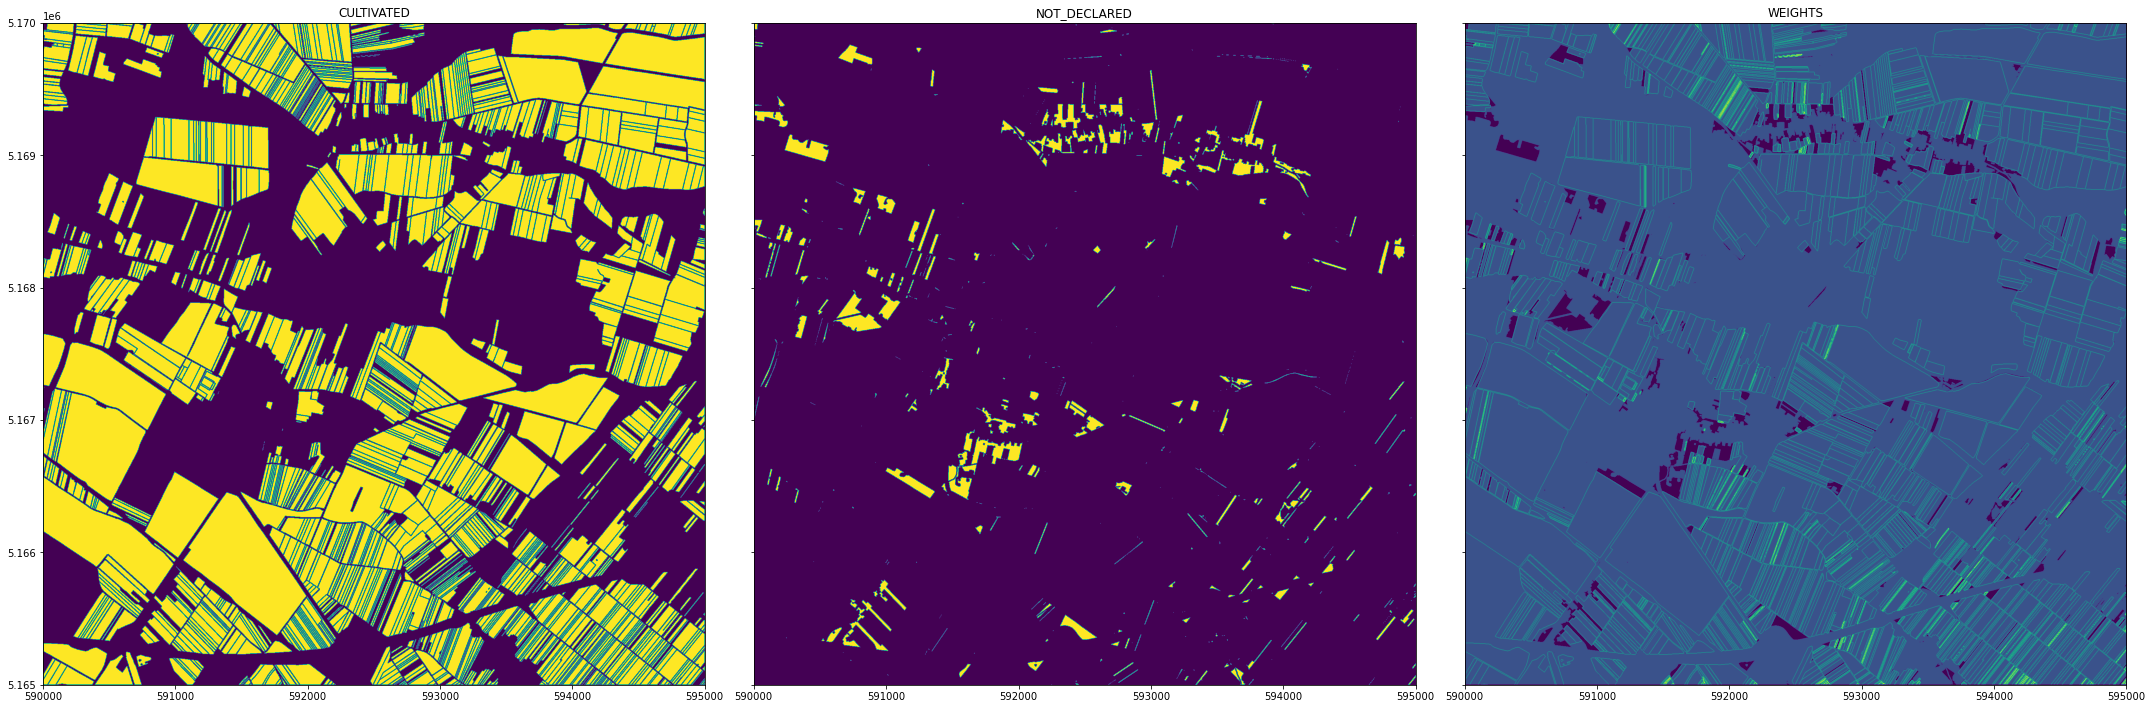

In [13]:
fig, axs = plt.subplots(figsize=(30, 10), ncols=3, sharey=True)

axs[0].imshow(eop.mask_timeless['CULTIVATED'].squeeze(), vmin=0, vmax=1, extent=get_extent(eop))
axs[0].set_title('CULTIVATED')

axs[1].imshow(eop.mask_timeless['NOT_DECLARED'].squeeze(), vmin=0, vmax=1, extent=get_extent(eop))
axs[1].set_title('NOT_DECLARED')

axs[2].imshow(eop.data_timeless['WEIGHTS'].squeeze(), vmin=0, vmax=4, extent=get_extent(eop))
axs[2].set_title('WEIGHTS')

plt.tight_layout();

Check if the stored images (std of ndvi) match the corresponding target maps and sample weights

In [ ]:
img = np.load('./data/train/01.npz')['arr_0']
gth = np.load('./data/train/01-gt.npz')['arr_0']
wht = np.load('./data/train/01-weights.npz')['arr_0']

plt.figure()
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(gth, cmap='gray')
plt.subplot(133)
plt.imshow(wht, cmap='gray')
plt.show()